### Stress Clasification with the 4 Simple

Model that being used
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- XGBoost

Missing values in each column:
MeanNN    0
pNN50     0
RMSSD     0
SDNN      0
Label     0
dtype: int64
Training set length: 76
Testing set length: 20

Logistic Regression Results:
Accuracy: 0.6000
Confusion Matrix:
[[6 6]
 [2 6]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7500    0.5000    0.6000        12
           1     0.5000    0.7500    0.6000         8

    accuracy                         0.6000        20
   macro avg     0.6250    0.6250    0.6000        20
weighted avg     0.6500    0.6000    0.6000        20


Random Forest Results:
Accuracy: 0.9000
Confusion Matrix:
[[11  1]
 [ 1  7]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9167    0.9167    0.9167        12
           1     0.8750    0.8750    0.8750         8

    accuracy                         0.9000        20
   macro avg     0.8958    0.8958    0.8958        20
weighted avg     0.9000    0.9000    0.9000   

c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8500
Confusion Matrix:
[[11  1]
 [ 2  6]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8462    0.9167    0.8800        12
           1     0.8571    0.7500    0.8000         8

    accuracy                         0.8500        20
   macro avg     0.8516    0.8333    0.8400        20
weighted avg     0.8505    0.8500    0.8480        20



C:\Users\ACER\AppData\Local\Temp\ipykernel_5076\844990728.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=accuracies, palette='viridis')


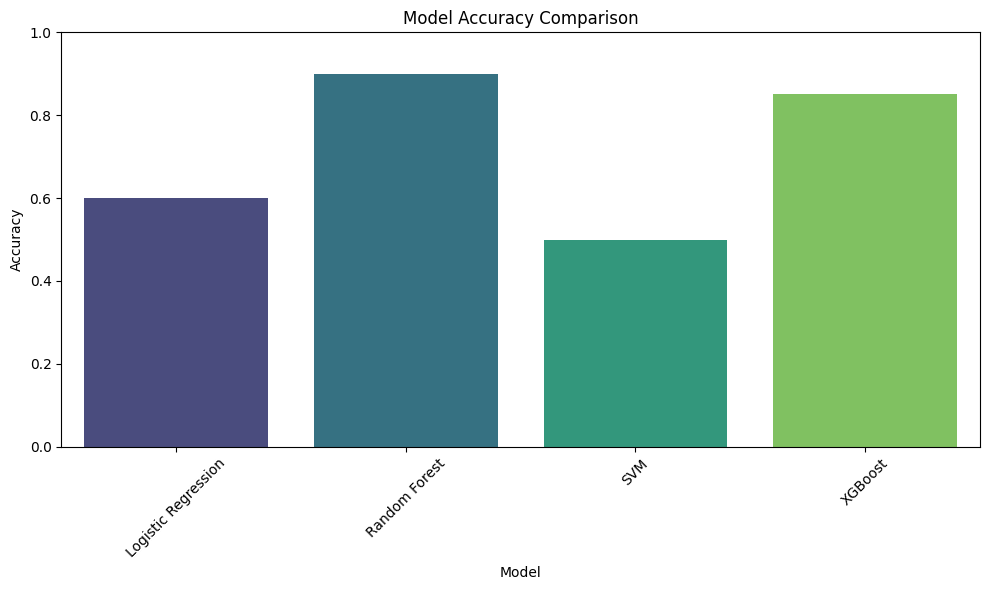

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Load datasets
rest_30 = pd.read_csv('rest_rppg_hrv_metrics_window-30s.csv')
stressor_30 = pd.read_csv('stressor_rppg_hrv_metrics_window-30s.csv')

rest_60 = pd.read_csv('rest_rppg_hrv_metrics_window-60s.csv')
stressor_60 = pd.read_csv('stressor_rppg_hrv_metrics_window-60s.csv')

rest_120 = pd.read_csv('rest_rppg_hrv_metrics_window-120s.csv')
stressor_120 = pd.read_csv('stressor_rppg_hrv_metrics_window-120s.csv')
# Combine datasets
rest = pd.concat([rest_30, rest_60, rest_120], ignore_index=True)
stressor = pd.concat([stressor_30, stressor_60, stressor_120], ignore_index=True)
## Merge and shuffle the rest and stressor
df = pd.concat([rest, stressor], ignore_index=True)
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Encode string labels to numeric
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set length: {len(train_df)}")
print(f"Testing set length: {len(test_df)}")

# Separate features and labels
X_train = train_df.drop('Label', axis=1)
y_train = train_df['Label']
X_test = test_df.drop('Label', axis=1)
y_test = test_df['Label']

# Define model pipelines
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),  # Optional for tree-based models but kept for consistency
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42, probability=True))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
}

# Train and evaluate
results = {}
for name, pipeline in pipelines.items():
    print(f"\n{name} Results:")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)

    results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

# Plot accuracy comparison
accuracies = [results[name]['accuracy'] for name in results]
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
